In [1]:
using DrWatson
@quickactivate "Doran_etal_2022"

In [2]:
using Muon
using LinearAlgebra
using Distances
using Statistics
using StatsPlots
using StatsBase
using Random: shuffle
using SPI

In [3]:
UP7047_NCOLS = 10117

10117

# Setup

In [4]:
biobank = readh5mu(joinpath(datadir(), "exp_pro", "BB673", "BB673.h5mu"))

MuData object 673 ✕ 11296
└ metabolites_foldchange
  AnnData object 673 ✕ 38
└ metabolites_millimolar
  AnnData object 673 ✕ 10
└ oggs
  AnnData object 673 ✕ 11248

In [5]:
pdir = plotsdir("BB673distanceplots")
mkpath(pdir)

"/Users/ben/projects/Doran_etal_2022/plots/BB673distanceplots"

In [6]:
keys(biobank["oggs"].obsm)

KeySet for a Muon.AlignedMapping{Tuple{1 => 1}, String, AnnData} with 1 entry. Keys:
  "inferredLSVs_UP7047"

In [7]:
SPImtx = biobank["oggs"].obsp["inferredSPIdist_UP7047"][:, :] ./ UP7047_NCOLS;

In [8]:
bbtaxa = biobank.obs[:,1:6];

673×4 adjoint(::Matrix{Float64}) with eltype Float64:
 -0.0557143  0.254286   10.9157   12.12
 -0.0507143  0.869286   13.1657   22.98
 -0.0557143  0.689286   15.2607   23.19
 -0.0389821  1.52696     8.10073  12.5242
 -0.0607143  0.0792857   5.07571  11.88
 -0.0678571  0.0121429   9.55661  18.3225
 -0.0428571  0.359643   12.2054   16.735
 -0.0507143  0.399286   12.3757   17.49
 -0.0457143  0.159286   11.5857   16.565
 -0.0707143  1.06929    13.1857   17.625
  ⋮                               
 14.875      1.95        0.73     27.335
  4.865      0.925       0.055    25.875
 -0.005      0.125       1.52      6.45
 17.905      2.695       1.385    27.835
  0.44       1.93        5.79      7.165
  0.005      0.415      -0.02      2.965
 -0.01       0.995       0.17      7.335
 16.595      2.455       1.1      28.265
 -0.02       0.12        7.985     8.33

In [26]:
# 4 Main metabolites  ["Acetate_mM", "Butyrate_mM", "Propionate_mM", "Succinate_mM"]
metabolitedistance = Distances.pairwise(Euclidean(), biobank["metabolites_millimolar"].X[:, 1:4]');
metabolitedistancerel = Distances.pairwise(Euclidean(), biobank["metabolites_foldchange"].X[:, :]');
metabolitedistance_mM = Distances.pairwise(Euclidean(), biobank["metabolites_millimolar"].X[:, :]');

# taxanomicdistance = begin
#     (bbtaxa.phylum .!=  permutedims(replace(bbtaxa.phylum, ""=>"missing"))) .+ 
#     (bbtaxa.class .!=  permutedims(replace(bbtaxa.class, ""=>"missing"))) .+
#     (bbtaxa.order .!=  permutedims(replace(bbtaxa.order, ""=>"missing"))) .+
#     (bbtaxa.family .!=  permutedims(replace(bbtaxa.family, ""=>"missing"))) .+
#     (bbtaxa.genus .!=  permutedims(replace(bbtaxa.genus, ""=>"missing")))  .+
#     (bbtaxa.species .!=  permutedims(replace(bbtaxa.species, ""=>"missing")))
# end;

# taxanomicdistance = begin
#     (bbtaxa.phylum .!=  permutedims(bbtaxa.phylum)) .+ 
#     (bbtaxa.class .!=  permutedims(bbtaxa.class)) .+
#     (bbtaxa.order .!=  permutedims(bbtaxa.order)) .+
#     (bbtaxa.family .!=  permutedims(bbtaxa.family)) .+
#     (bbtaxa.genus .!=  permutedims(bbtaxa.genus))  .+
#     (bbtaxa.species .!=  permutedims(bbtaxa.species))
# end;

taxanomicdistance = pairwise(eachrow(Matrix(bbtaxa)[:,6:-1:1])) do a, b
    x = findfirst(a .== replace(b, ""=>"missing"))
    x === nothing ? 6 : x-1
end;

In [27]:
oggeuclideandistance = Distances.pairwise(Euclidean(), biobank["oggs"].X[:, :]')
BBusv = svd(biobank["oggs"].X[:, :])
BBsvdeuclideandistance = Distances.pairwise(Euclidean(), BBusv.U[:, 1:10]');
UPsvdeuclideandistance = Distances.pairwise(Euclidean(), biobank["oggs"].obsm["inferredLSVs_UP7047"][:, 1:10]');
BBSPImtx = calc_spi_mtx(BBusv.U, BBusv.S, getintervals(BBusv.S)) ./ size(BBusv.V,1);

In [28]:
taxaranklabels = string.([:phylum :class :order :family :genus :species])
taxarankcolors = [:grey :red :pink :orange :lightblue :green :aqua]|> reverse;

In [29]:
uppertriangle = triu(trues(673, 673), 1);

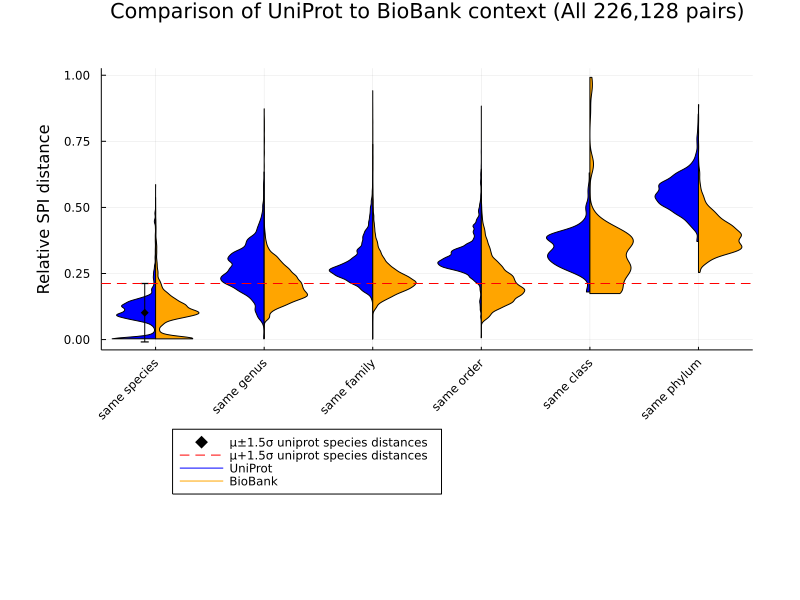

In [30]:
n = 6
labels = ["same species", "same genus", "same family", "same order", "same class", "same phylum", "different phylum"];
plot(size=(800,600), 
    title="Comparison of UniProt to BioBank context (All 226,128 pairs)", 
    ylabel="Relative SPI distance", 
    # format=:png, dpi=200,
    margin=10Plots.Measures.mm,
    xticks=(1:n, labels[1:n]),
    xlims=(.5, n +.5),
    xrotation=45,
    legend=:outerbottom,
)
xdata = taxanomicdistance[uppertriangle]
ydata1 = (SPImtx ./ maximum(SPImtx))[uppertriangle]
ydata2 = (BBSPImtx ./ maximum(BBSPImtx))[uppertriangle]
for i in 0:n
    mask = xdata .== i
    violin!(xdata[mask].+1, ydata1[mask],
        label="",
        c=:blue, 
        side=:left)
    violin!(xdata[mask].+1, ydata2[mask],
        label="",
        c=:orange, 
        side=:right)
end
allspeciesdists = ydata1[xdata.==0]
allspeciesdists2 = ydata2[xdata.==0]
scatter!([.9], [mean(allspeciesdists)], yerror=1.5std(allspeciesdists), c=:black, label="μ±1.5σ uniprot species distances", shape=:diamond)
# scatter!([1.1], [mean(allspeciesdists2)], yerror=1.5std(allspeciesdists2), c=:black,  shape=:diamond)
# hline!([mean(allspeciesdists)+std(allspeciesdists)], c=:red, linestyle=:dash)
hline!([mean(allspeciesdists)+1.5std(allspeciesdists)], c=:red, label="μ+1.5σ uniprot species distances", linestyle=:dash)
# hline!([mean(allspeciesdists2)+1.5std(allspeciesdists2)], c=:orange, linestyle=:dash)
plot!([0 0], c=[:blue :orange], label=["UniProt" "BioBank"])
plot!()

In [37]:
savefig(joinpath(pdir, "SPIdistUPvsSPIdistBB_splitbyNCBItaxonomy_groupedviolin.pdf"))

# Conflated pairs

In [31]:
xdata = taxanomicdistance
Nconflated = Float64[]
methodsmatrices = [SPImtx, BBSPImtx]
for ydata in methodsmatrices
    allspeciesdists = ydata[uppertriangle][taxanomicdistance[uppertriangle].==0]
    θ = mean(allspeciesdists) + 1.5std(allspeciesdists)
    for i in 1:5
        mask = xdata[uppertriangle] .== i
        push!(Nconflated, sum(ydata[uppertriangle][mask] .< θ))
    end
end
Nconflated = reshape(Nconflated, (5,length(methodsmatrices)))

5×2 Matrix{Float64}:
 3562.0   8311.0
 5394.0  24099.0
  820.0  16448.0
    5.0     40.0
    0.0      0.0

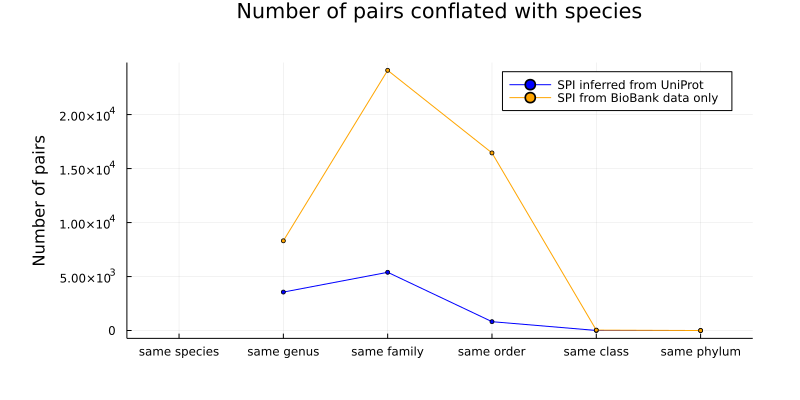

In [32]:
labels = ["same species", "same genus", "same family", "same order", "same class", "same phylum"];
plot(size=(800,400), title="Number of pairs conflated with species", ylabel="Number of pairs", 
    # format=:png, dpi=200,
    margin=10Plots.Measures.mm,
    xticks=(1:6, labels),
    xlims=(.5, 6.5),
    # legend=:none,
)
plot!(2:6, 
    c=[:blue :orange],
    reshape(Nconflated, (5,length(methodsmatrices))), 
    label=["SPI inferred from UniProt" "SPI from BioBank data only" ], 
    lw=1, markersize=3, marker=true)

In [97]:
savefig(joinpath(pdir, "counts_of_pairs_conflated_with_species_by_distancemethod.pdf"))

In [33]:
ydata1 = SPImtx ./ maximum(SPImtx)
ydata2 = BBSPImtx ./ maximum(BBSPImtx)

allspeciesdists = ydata1[uppertriangle][taxanomicdistance[uppertriangle].==0]
allspeciesdists2 = ydata2[uppertriangle][taxanomicdistance[uppertriangle].==0]

threshold = mean(allspeciesdists)+1.5std(allspeciesdists)

allorderdists = ydata1[uppertriangle][taxanomicdistance[uppertriangle].==3]
allorderdists2 = ydata2[uppertriangle][taxanomicdistance[uppertriangle].==3];

In [34]:
BB673pairs_UPcontext = intersect(findall(<(threshold), ydata1), findall(==(4), taxanomicdistance))
BB673pairs_BBcontext = intersect(findall(<(threshold), ydata2), findall(==(4), taxanomicdistance));

In [35]:
BB673pairs_UPcontext |> length, BB673pairs_BBcontext |> length, intersect(BB673pairs_BBcontext, BB673pairs_UPcontext) |> length, 78-10

(10, 78, 10, 68)

In [36]:
BB673pairs_UPcontext |> length, BB673pairs_BBcontext |> length, intersect(BB673pairs_BBcontext, BB673pairs_UPcontext) |> length

(10, 78, 10)

In [37]:
(1640 - 1354) / 2, (30406 - 1354) / 2, 1354 /2, 30406 / 2

(143.0, 14526.0, 677.0, 15203.0)

In [38]:
unique(getindex.(BB673pairs_UPcontext, 1)) |> length

6

In [39]:
unique(getindex.(BB673pairs_BBcontext, 1)) |> length

13

In [40]:
biobank.obs_names[unique(getindex.(BB673pairs_BBcontext, 1))]

13-element Vector{String}:
 "DFI.1.4_Anaerostipes_caccae"
 "DFI.1.3_Anaerostipes_caccae"
 "DFI.1.5_Anaerostipes_caccae"
 "DFI.1.94_Anaerostipes_caccae"
 "DFI.1.19_Anaerostipes_caccae"
 "DFI.1.13_Anaerostipes_caccae"
 "MSK.15.233_Lachnospiraceae_bacterium_EP-SM-12S-S03"
 "DFI.3.107_Lachnospiraceae_bacterium_210521-DFI.3.107"
 "MSK.1.24_Sellimonas_intestinalis"
 "MSK.1.25_Sellimonas_intestinalis"
 "MSK.1.19_Sellimonas_intestinalis"
 "MSK.1.20_Sellimonas_intestinalis"
 "MSK.1.21_Sellimonas_intestinalis"

In [45]:
biobank.obs[unique(getindex.(BB673pairs_BBcontext, 1)), 2:end]

13×6 DataFrame
 Row │ class       order          family            genus                      ⋯
     │ String      String         String            String                     ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │ Clostridia  Clostridiales  Lachnospiraceae   Anaerostipes               ⋯
   2 │ Clostridia  Clostridiales  Lachnospiraceae   Anaerostipes
   3 │ Clostridia  Clostridiales  Lachnospiraceae   Anaerostipes
   4 │ Clostridia  Clostridiales  Lachnospiraceae   Anaerostipes
   5 │ Clostridia  Clostridiales  Lachnospiraceae   Anaerostipes               ⋯
   6 │ Clostridia  Clostridiales  Lachnospiraceae   Anaerostipes
   7 │ Clostridia  Clostridiales  Lachnospiraceae   unclassified Lachnospirace
   8 │ Clostridia  Clostridiales  Lachnospiraceae   Mediterraneibacter
   9 │ Clostridia  Eubacteriales  Oscillospiraceae  Drancourtella              ⋯
  10 │ Clostridia  Eubacteriales  Oscillospiraceae  Drancourtella
  11 │ Clostridia  Eubacteriales  Oscillospiraceae  Drancourtella
  12 │ Clostridia  Eubacteriales  Oscillospiraceae  Drancourtella
  13 │ Clostridia  Eubacteriales  Oscillospiraceae  Drancourtella              ⋯
                                                               3 columns omitted

In [71]:
speciescontacts = [ones(Int, 6,6) zeros(Int, 6,7);
 zeros(Int, 2,6) diagm([1,1]) zeros(Int, 2,5);
 zeros(Int, 5,8) ones(Int, 5,5);
] * 2;

conflated_species_idx = unique(getindex.(BB673pairs_BBcontext,1))
diffmtx = Int.(ydata1[conflated_species_idx, conflated_species_idx] .< threshold)  .+ # up context
    Int.(ydata2[conflated_species_idx, conflated_species_idx] .< threshold)  .- # bb context
    speciescontacts # pairs that should be below threshold

13×13 Matrix{Int64}:
 0  0  0  0  0  0  0  1  1  1  1  1  1
 0  0  0  0  0  0  0  0  1  1  1  1  1
 0  0  0  0  0  0  0  1  1  1  1  1  1
 0  0  0  0  0  0  0  0  1  1  1  1  1
 0  0  0  0  0  0  0  1  1  1  1  1  1
 0  0  0  0  0  0  0  0  1  1  1  1  1
 0  0  0  0  0  0  0  0  2  2  2  2  2
 1  0  1  0  1  0  0  0  1  1  1  0  1
 1  1  1  1  1  1  2  1  0  0  0  0  0
 1  1  1  1  1  1  2  1  0  0  0  0  0
 1  1  1  1  1  1  2  1  0  0  0  0  0
 1  1  1  1  1  1  2  0  0  0  0  0  0
 1  1  1  1  1  1  2  1  0  0  0  0  0

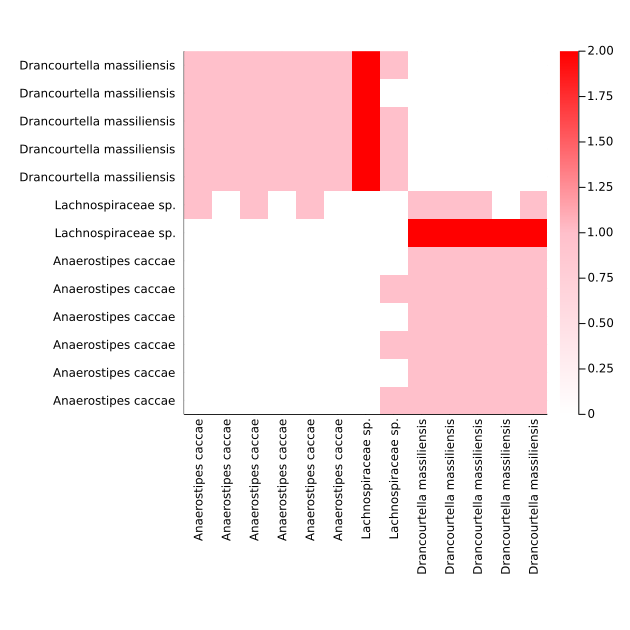

In [72]:
plot(
    yticks=(1:13, bbtaxa.species[unique(getindex.(BB673pairs_BBcontext, 1))]),
    xticks=(1:13, bbtaxa.species[unique(getindex.(BB673pairs_BBcontext, 1))]),
    xrotation = 90,
    ratio=1,
    size=(630,630),
    margin=3Plots.Measures.mm,
)
heatmap!(diffmtx, 
    c=[:white, :pink, :red], 
    # clims=(-maximum(extrema(diffmtx)), maximum(extrema(diffmtx))),
)

In [240]:
savefig(joinpath(pdir, "Pairs_conflated_at_class_heatmap.pdf"))

In [73]:
splitdiffmtx = .-(tril(diffmtx) .> 1) + (triu(diffmtx) .> 0)

13×13 Matrix{Int64}:
 0  0  0  0  0  0   0  1  1  1  1  1  1
 0  0  0  0  0  0   0  0  1  1  1  1  1
 0  0  0  0  0  0   0  1  1  1  1  1  1
 0  0  0  0  0  0   0  0  1  1  1  1  1
 0  0  0  0  0  0   0  1  1  1  1  1  1
 0  0  0  0  0  0   0  0  1  1  1  1  1
 0  0  0  0  0  0   0  0  1  1  1  1  1
 0  0  0  0  0  0   0  0  1  1  1  0  1
 0  0  0  0  0  0  -1  0  0  0  0  0  0
 0  0  0  0  0  0  -1  0  0  0  0  0  0
 0  0  0  0  0  0  -1  0  0  0  0  0  0
 0  0  0  0  0  0  -1  0  0  0  0  0  0
 0  0  0  0  0  0  -1  0  0  0  0  0  0

In [74]:
sum(splitdiffmtx .== -1)

5

In [75]:
sum(splitdiffmtx .== 1)

42

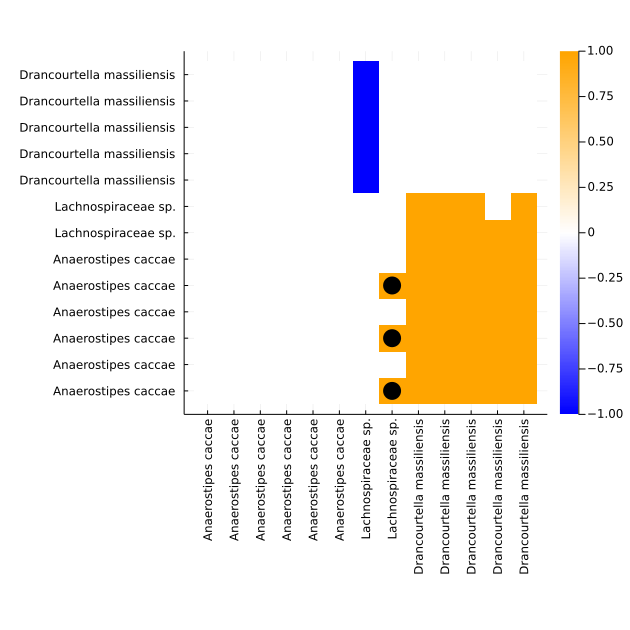

In [85]:
plot(
    yticks=(1:13, bbtaxa.species[unique(getindex.(BB673pairs_BBcontext, 1))]),
    xticks=(1:13, bbtaxa.species[unique(getindex.(BB673pairs_BBcontext, 1))]),
    xrotation = 90,
    ratio=1,
    size=(630,630),
    margin=3Plots.Measures.mm,
)
heatmap!(.-(tril(diffmtx) .> 1) + (triu(diffmtx) .> 0),
    c=[:blue, :white, :orange])
scatter!([(8,1), (8, 3), (8,5)], c=:black, label=:none, markersize=10)

In [77]:
savefig(joinpath(pdir, "Pairs_conflated_at_class_heatmap_split_on_diagonal.pdf"))

# Other violin plots

In [ ]:
n = 6
labels = ["same species", "same genus", "same family", "same order", "same class", "same phylum", "different phylum"];
plot(size=(800,400), title="SPI distance inferred from UniProt (All 226,128 pairs)", ylabel="SPI distance", 
    # format=:png, dpi=200,
    margin=10Plots.Measures.mm,
    xticks=(1:n, labels[1:n]),
    xlims=(.5, n +.5),
    legend=:none,
)
xdata = taxanomicdistance
ydata = SPImtx
for i in 0:n
    mask = xdata .== i
    violin!(xdata[mask].+1, ydata[mask],
        label=labels[i+1],
        xrotation=45,
        c=taxarankcolors[i+1],
        # hover=bbtaxa.species[mask], 
        alpha=1, markerstrokewidth=0, markersize=2,
    )
end
allspeciesdists = ydata[uppertriangle][taxanomicdistance[uppertriangle].==0]
scatter!([mean(allspeciesdists)], yerror=1.5std(allspeciesdists), c=:black, shape=:diamond)
# hline!([mean(allspeciesdists)+std(allspeciesdists)], c=:red, linestyle=:dash)
hline!([mean(allspeciesdists)+1.5std(allspeciesdists)], c=:red, linestyle=:dash)
plot!()

In [ ]:
# savefig(joinpath(pdir, "SPIdistUP_groupedby_NCBItaxonomy_violin.pdf"))
savefig(joinpath(pdir, "SPIdistUP_groupedby_NCBItaxonomy_6mainlevels_violin.pdf"))

In [ ]:
n = 6
labels = ["same species", "same genus", "same family", "same order", "same class", "same phylum", "different phylum"];
plot(size=(800,400), title="SPI distance using BioBank data only (All 226,128 pairs)", ylabel="SPI distance ", 
    # format=:png, dpi=200,
    margin=10Plots.Measures.mm,
    xticks=(1:n, labels),
    xlims=(.5, n + .5),
    legend=:none,
)
xdata = taxanomicdistance
ydata = BBSPImtx
for i in 0:n-1
    mask = xdata .== i
    violin!(xdata[mask].+1, ydata[mask],
        label=labels[i+1],
        xrotation=45,
        c=taxarankcolors[i+1],
        # hover=bbtaxa.species[mask], 
        alpha=1, markerstrokewidth=0, markersize=2,
    )
end
allspeciesdists = ydata[uppertriangle][taxanomicdistance[uppertriangle].==0]
scatter!([mean(allspeciesdists)], yerror=1.5std(allspeciesdists), c=:black, shape=:diamond)
# hline!([mean(allspeciesdists)+std(allspeciesdists)], c=:red, linestyle=:dash)
hline!([mean(allspeciesdists)+1.5std(allspeciesdists)], c=:red, linestyle=:dash)
plot!()

In [ ]:
# savefig(joinpath(pdir, "SPIdistBB_groupedby_NCBItaxonomy_violin.pdf"))
savefig(joinpath(pdir, "SPIdistBB_groupedby_NCBItaxonomy_6mainlevels_violin.pdf"))

In [ ]:
labels = ["same species", "same genus", "same family", "same order", "same class", "same phylum", "different phylum"];
plot(size=(800,400), title="Euclidean distance of top 10 BioBank PCs (All 226,128 pairs)", ylabel="Euclidean distance", 
    # format=:png, dpi=200,
    margin=10Plots.Measures.mm,
    xticks=(1:7, labels),
    xlims=(.5, 7.5),
    legend=:none,
)
xdata = taxanomicdistance
ydata = BBsvdeuclideandistance
for i in sort(unique(xdata))
    mask = xdata .== i
    violin!(xdata[mask].+1, ydata[mask],
        label=labels[i+1],
        xrotation=45,
        c=taxarankcolors[i+1],
        # hover=bbtaxa.species[mask], 
        alpha=1, markerstrokewidth=0, markersize=2,
    )
end
allspeciesdists = ydata[uppertriangle][taxanomicdistance[uppertriangle].==0]
scatter!([mean(allspeciesdists)], yerror=1.5std(allspeciesdists), c=:black, shape=:diamond)
# hline!([mean(allspeciesdists)+std(allspeciesdists)], c=:red, linestyle=:dash)
hline!([mean(allspeciesdists)+1.5std(allspeciesdists)], c=:red, linestyle=:dash)
plot!()

In [ ]:
savefig(joinpath(pdir, "BBsvdeuclidean_groupedby_NCBItaxonomy_violin.pdf"))

In [ ]:
labels = ["same species", "same genus", "same family", "same order", "same class", "same phylum", "different phylum"];
plot(size=(800,400), title="Euclidean of top 10 inferred UniProt PCs (All 226,128 pairs)", ylabel="Euclidean distance", 
    # format=:png, dpi=200,
    margin=10Plots.Measures.mm,
    xticks=(1:7, labels),
    xlims=(.5, 7.5),
    legend=:none,
)
xdata = taxanomicdistance
ydata = UPsvdeuclideandistance
for i in sort(unique(xdata))
    mask = xdata .== i
    violin!(xdata[mask].+1, ydata[mask],
        label=labels[i+1],
        xrotation=45,
        c=taxarankcolors[i+1],
        # hover=bbtaxa.species[mask], 
        alpha=1, markerstrokewidth=0, markersize=2,
    )
end
allspeciesdists = ydata[uppertriangle][taxanomicdistance[uppertriangle].==0]
scatter!([mean(allspeciesdists)], yerror=1.5std(allspeciesdists), c=:black, shape=:diamond)
# hline!([mean(allspeciesdists)+std(allspeciesdists)], c=:red, linestyle=:dash)
hline!([mean(allspeciesdists)+1.5std(allspeciesdists)], c=:red, linestyle=:dash)
plot!()

In [ ]:
savefig(joinpath(pdir, "UPsvdeuclidean_groupedby_NCBItaxonomy_violin.pdf"))

## Individual Metabolites

In [ ]:
# individual metabolites
titles = vcat(biobank["metabolites_foldchange"].var_names, biobank["metabolites_millimolar"].var_names[1:4]);
metabolite_matrix = hcat(biobank["metabolites_foldchange"].X[:,:], biobank["metabolites_millimolar"].X[:,1:4]);
plot(layout=grid(6,7), size=(1000, 900), margin=3Plots.Measures.mm)
for i in 1:size(metabolite_matrix,2)
    mdist = Distances.pairwise(Euclidean(), metabolite_matrix[:,i]');
    xy = (SPImtx[uppertriangle], mdist[uppertriangle])
    histogram2d!(xy, xlabel=titles[i], xguidefontsize=7, sp=i, colorbar=:none, ticks=:none)
end
plot!()

In [ ]:
savefig(joinpath(pdir, "x=SPIdist_y=individualmetabolitedistance_grid_heatmap.pdf"))

# Subset scatter plot

In [ ]:
vulgatusindicesBB = findall(bbtaxa.species .== "Phocaeicola vulgatus");
staphmask = BitVector(zeros(length(vulgatusindicesBB)))
staphmask[findfirst(s->contains(s, "MSK.7.24"), biobank.obs_names[vulgatusindicesBB])] = 1;
smalluppertriangle = triu(trues(length(vulgatusindicesBB)-1,length(vulgatusindicesBB)-1), 1);

In [ ]:
binomial(89, 2)

In [ ]:
plot(title="89 B. vulgatus isolates → (3916 pairs)", 
    ylabel="Metabolic Similarity (euclidean(ΔmM))",
    xlabel="Spectral Similarity (SPI distance)",
    margin=3Plots.Measures.mm,
    ylims=(-0.01,9),
    xlims=(-0.01,11.5),
    )
scatter!(
    SPImtx[vulgatusindicesBB[.!staphmask],vulgatusindicesBB[.!staphmask]][smalluppertriangle], 
    metabolitedistance[vulgatusindicesBB[.!staphmask],vulgatusindicesBB[.!staphmask]][smalluppertriangle],
    alpha=0.1,
    markersize=2,
    label="",
    c=:black)
scatter!(
    SPImtx[vulgatusindicesBB[staphmask],vulgatusindicesBB[.!staphmask]], 
    metabolitedistance[vulgatusindicesBB[staphmask],vulgatusindicesBB[.!staphmask]],
    alpha=.2,
    markersize=2,
    label="",
    c=:red)

In [ ]:
savefig(joinpath(pdir, "Bvulgatus_metabolic_by_SPIdistance_scatter.pdf"))

In [183]:
# subsetmaskBB = findall(contains("uniformis"), bbtaxa.species);
# smalluppertriangle = triu(trues(length(subsetmaskBB),length(subsetmaskBB)), 1);
subsetmaskBB = findall(contains("gnavus"), bbtaxa.species);
smalluppertriangle = triu(trues(length(subsetmaskBB),length(subsetmaskBB)), 1);

subsetmaskBB_firm = findall(contains("gnavus"), bbtaxa.species);
subsetmaskBB_bact = findall(contains("uniformis"), bbtaxa.species);

In [184]:
binomial(length(subsetmaskBB), 2)

820

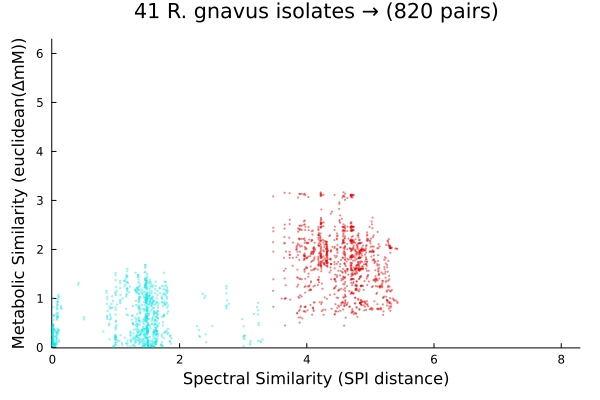

In [185]:
plot(title="$(length(subsetmaskBB)) R. gnavus isolates → ($(binomial(length(subsetmaskBB), 2)) pairs)", 
    ylabel="Metabolic Similarity (euclidean(ΔmM))",
    xlabel="Spectral Similarity (SPI distance)",
    margin=3Plots.Measures.mm,
    grid=false,
    ylims=(-0.01,6.3),
    xlims=(-0.01,8.3),
    
    )
scatter!(
    SPImtx[subsetmaskBB,subsetmaskBB][smalluppertriangle], 
    metabolitedistance[subsetmaskBB,subsetmaskBB][smalluppertriangle],
    alpha=0.5,
    markersize=2,
    label="",
    markerstrokewidth=0,
    c=:aqua)

scatter!(
    SPImtx[subsetmaskBB_firm,subsetmaskBB_bact][:], 
    metabolitedistance[subsetmaskBB_firm,subsetmaskBB_bact][:],
    alpha=0.5,
    markersize=2,
    label="",
    markerstrokewidth=0,
    c=:red)

In [179]:
savefig(joinpath(pdir, "Rgnavus_Buniformis_subset_metabolic_by_SPIdistance_scatter.pdf"))

# Full Scatter Plot

In [ ]:
plot(title="673 BioBank isolates → (226,128 pairs)", 
    ylabel="Metabolic Similarity (euclidean(ΔmM))",
    xlabel="Spectral Similarity (SPI distance)",
    margin=3Plots.Measures.mm,
    ylims=(-0.01,9),
    xlims=(-0.01,11.5))
scatter!(
    SPImtx[uppertriangle], 
    metabolitedistance[uppertriangle],
    alpha=0.1,
    markersize=2,
    label="",
    c=:black)

In [ ]:
savefig(joinpath(pdir, "BB673_metabolic_by_SPIdistance_scatter.pdf"))

In [114]:
# regression
x = hcat(ones(length(SPImtx[uppertriangle])), SPImtx[uppertriangle])
y = metabolitedistance[uppertriangle]
betas = inv(x'x) * x' * y

2-element Vector{Float64}:
 1.1381036229174448
 0.351393822219916

In [124]:
cor(SPImtx[uppertriangle], metabolitedistance[uppertriangle])

0.32290733801361315

In [126]:
using GLM

In [128]:
lm(x, y)

LinearModel{GLM.LmResp{Vector{Float64}}, GLM.DensePredChol{Float64, CholeskyPivoted{Float64, Matrix{Float64}}}}:

Coefficients:
────────────────────────────────────────────────────────────────
       Coef.  Std. Error       t  Pr(>|t|)  Lower 95%  Upper 95%
────────────────────────────────────────────────────────────────
x1  1.1381    0.0087589   129.94    <1e-99   1.12094    1.15527
x2  0.351394  0.00216586  162.24    <1e-99   0.347149   0.355639
────────────────────────────────────────────────────────────────


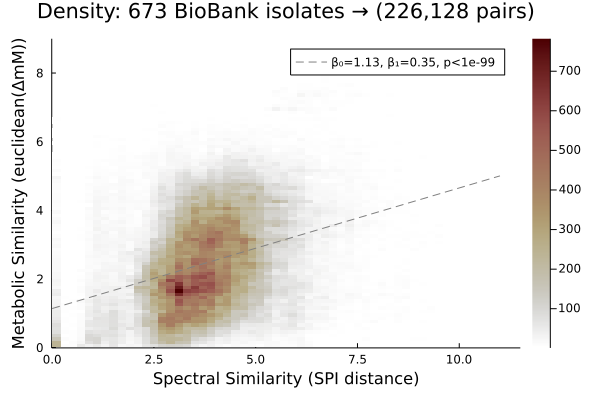

In [131]:
plot(title="Density: 673 BioBank isolates → (226,128 pairs)", 
    ylabel="Metabolic Similarity (euclidean(ΔmM))",
    xlabel="Spectral Similarity (SPI distance)",
    margin=3Plots.Measures.mm,
    ylims=(-0.01,9),
    xlims=(-0.01,11.5))
histogram2d!(
    SPImtx[uppertriangle], 
    metabolitedistance[uppertriangle],
    nbins=100,
    # alpha=0.1,
    c=:bilbao,
    grid=false,
    markersize=2,
    label="")
plot!(x-> betas[2]*x + betas[1], 0:11.5, ls=:dash, c=:grey, label="β₀=1.13, β₁=0.35, p<1e-99")


In [132]:
savefig(joinpath(pdir, "BB673_SPIvsMetabolic_density_withLM.pdf"))

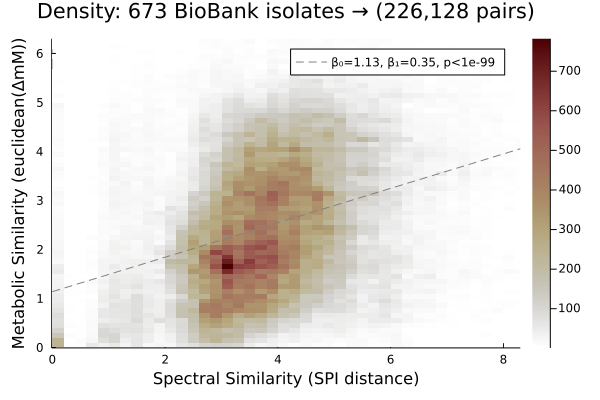

In [134]:
plot(title="Density: 673 BioBank isolates → (226,128 pairs)", 
    ylabel="Metabolic Similarity (euclidean(ΔmM))",
    xlabel="Spectral Similarity (SPI distance)",
    margin=3Plots.Measures.mm,
    ylims=(-0.01,6.3),
    xlims=(-0.01,8.3))
histogram2d!(
    SPImtx[uppertriangle], 
    metabolitedistance[uppertriangle],
    nbins=100,
    # alpha=0.1,
    c=:bilbao,
    grid=false,
    markersize=2,
    label="")
plot!(x-> betas[2]*x + betas[1], 0:11.5, ls=:dash, c=:grey, label="β₀=1.13, β₁=0.35, p<1e-99")


In [135]:
savefig(joinpath(pdir, "BB673_SPIvsMetabolic_density_withLM_zoomedin.pdf"))

# 2d Histogrames
## Number of pairs in 2d grid

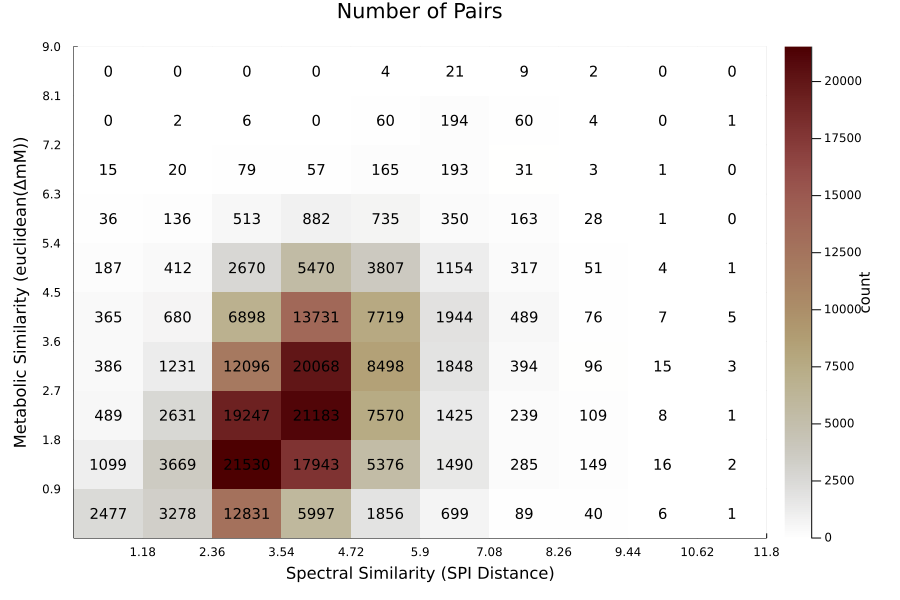

In [101]:
nbinsperside = 10 + 1
xy = (metabolitedistance[uppertriangle], SPImtx[uppertriangle])
ext = extrema.(xy)
edges = (
    range(0.0-1e-10, 9+1e-15, length=nbinsperside),
    range(0.0-1e-10, 11.8+1e-15, length=nbinsperside),
)
h2d = fit(Histogram, xy, edges)
outeredge = 10
marks = 1:1:outeredge
p1 = plot(
    size=(900,600),
    title="Number of Pairs",
    ylabel="Metabolic Similarity (euclidean(ΔmM))", 
    xlabel="Spectral Similarity (SPI Distance)",
    colorbartitle="count",
    yticks=(marks.+.5, round.(quantile(edges[1], (marks) ./10), digits=2)),
    xticks=(marks.+.5, round.(quantile(edges[2], (marks) ./10), digits=2)),
    margin=5Plots.Measures.mm)
p1 = heatmap!(h2d.weights[1:outeredge, 1:outeredge], c=:bilbao)
for i in CartesianIndices(h2d.weights[1:outeredge, 1:outeredge])
    annotate!(i[2], i[1], text(string(h2d.weights[i]), 10))
end
plot!()

In [ ]:
savefig(joinpath(pdir, "spi-by-met4mm_numpairs_100bins_allbins.pdf"))

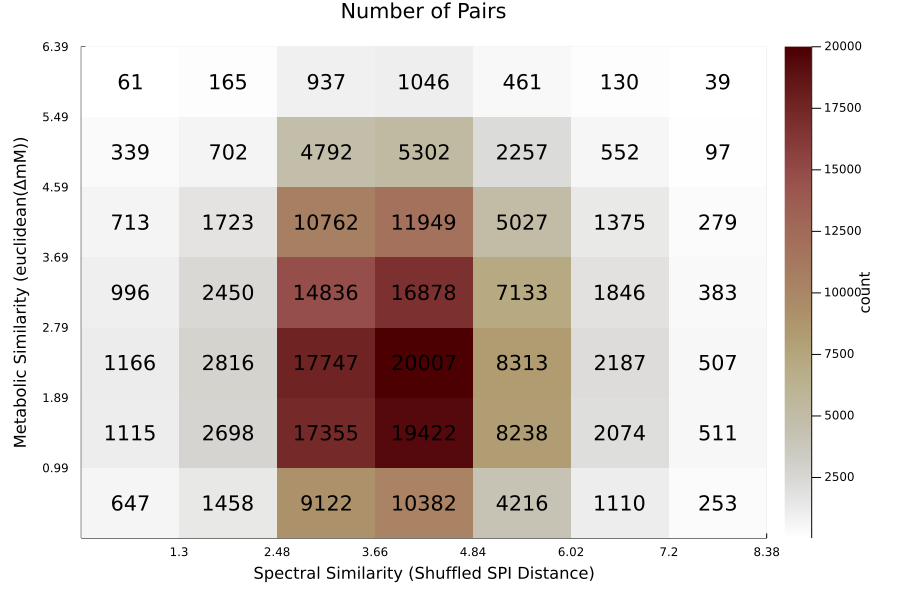

In [102]:
nbinsperside = 10 + 1
xy = (metabolitedistance[uppertriangle], shuffle(SPImtx[uppertriangle]))
ext = extrema.(xy)
edges = (
    range(0.0-1e-10, 9+1e-15, length=nbinsperside),
    range(0.0-1e-10, 11.8+1e-15, length=nbinsperside),
)
h2d = fit(Histogram, xy, edges)
outeredge = 7
marks = 1:1:outeredge
p1 = plot(
    size=(900,600),
    title="Number of Pairs",
    ylabel="Metabolic Similarity (euclidean(ΔmM))", 
    xlabel="Spectral Similarity (Shuffled SPI Distance)",
    colorbartitle="count",
    yticks=(marks.+.5, round.(quantile(edges[1], (marks.+.1) ./10), digits=2)),
    xticks=(marks.+.5, round.(quantile(edges[2], (marks.+.1) ./10), digits=2)),
    margin=5Plots.Measures.mm)
p1 = heatmap!(h2d.weights[1:outeredge, 1:outeredge], c=:bilbao)
for i in CartesianIndices(h2d.weights[1:outeredge, 1:outeredge])
    annotate!(i[2], i[1], string(h2d.weights[i]))
end
plot!()

In [ ]:
savefig(joinpath(pdir, "spi-by-met4mm_numpairs_permutation_100bins.pdf"))

## 2d Hist ratio fold change

In [105]:
BBsamephylum = bbtaxa.phylum .== permutedims(replace(bbtaxa.phylum, ""=>"missing"))
BBsameorder = bbtaxa.order .== permutedims(replace(bbtaxa.order, ""=>"missing"))
BBsamegenus = bbtaxa.genus .== permutedims(replace(bbtaxa.genus, ""=>"missing"))
# BBsamephylum = bbtaxa.phylum .== permutedims(bbtaxa.phylum)
# BBsameorder = bbtaxa.order .== permutedims(bbtaxa.order)
# BBsamegenus = bbtaxa.genus .== permutedims(bbtaxa.genus)
uppertriangle = triu(trues(size(BBsamegenus)), 1);

In [106]:
using Random: shuffle
using StatsBase
xy = (metabolitedistance[uppertriangle], SPImtx[uppertriangle])
ext = extrema.(xy)
# edges = Tuple(range(l-1e-15,h+1e-15, length=101) for (l, h) in ext)
edges = (
    range(0.0-1e-10, 9+1e-15, length=101),
    range(0.0-1e-10, 11.8+1e-15, length=101),
)
h2d = fit(Histogram, xy, edges)
phylumh2d = fit(Histogram, (metabolitedistance[BBsamephylum .& uppertriangle], SPImtx[BBsamephylum .& uppertriangle]), edges)
orderh2d = fit(Histogram, (metabolitedistance[BBsameorder .& uppertriangle], SPImtx[BBsameorder .& uppertriangle]), edges)
genush2d = fit(Histogram, (metabolitedistance[BBsamegenus .& uppertriangle], SPImtx[BBsamegenus .& uppertriangle]), edges);
notphylumh2d = fit(Histogram, (metabolitedistance[.!BBsamephylum .& uppertriangle], SPImtx[.!BBsamephylum .& uppertriangle]), edges);
notorderh2d = fit(Histogram, (metabolitedistance[.!BBsameorder .& uppertriangle], SPImtx[.!BBsameorder .& uppertriangle]), edges);
notgenush2d = fit(Histogram, (metabolitedistance[.!BBsamegenus .& uppertriangle], SPImtx[.!BBsamegenus .& uppertriangle]), edges);


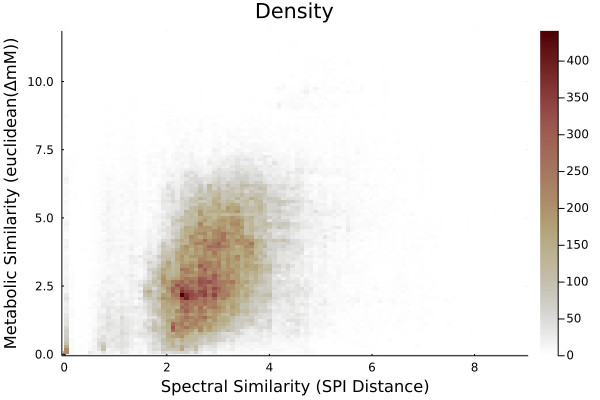

In [111]:
p1 = plot(
    title="Density of pairs ",
    ylabel="Metabolic Similarity (euclidean(ΔmM))", 
    xlabel="Spectral Similarity (SPI Distance)",
    )
heatmap!(h2d, c=:bilbao)


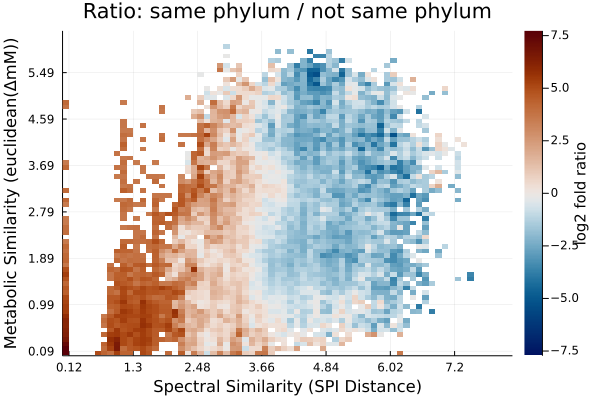

In [107]:
outeredge = 70
marks = 1:10:outeredge
p1 = plot(
    title="Ratio: same phylum / not same phylum",
    ylabel="Metabolic Similarity (euclidean(ΔmM))", 
    xlabel="Spectral Similarity (SPI Distance)",
    colorbartitle="log2 fold ratio",
    yticks=(marks.+.5, round.(quantile(edges[1], marks./100), digits=2)),
    xticks=(marks.+.5, round.(quantile(edges[2], marks./100), digits=2)),
    )
foldchange_mtx = log2.((phylumh2d.weights.+1) ./ (notphylumh2d.weights.+1))
working_clims = maximum(abs.(extrema(foldchange_mtx))) |> (x)->(-x, x)
foldchange_mtx[foldchange_mtx .== 0.0] .= NaN
smallbinmask = phylumh2d.weights .+ notphylumh2d.weights .< 11
foldchange_mtx[smallbinmask] .= NaN
heatmap!(foldchange_mtx[1:outeredge, 1:outeredge], clims=working_clims, c=:vik)


In [ ]:
savefig(joinpath(pdir, "spi-by-met4mm_binned-Phylum-ratio_heatmap.pdf"))

In [ ]:
outeredge = 70
marks = 1:10:outeredge
p1 = plot(
    title="Ratio: same order / not same order",
    ylabel="Metabolic Similarity (euclidean(ΔmM))", 
    xlabel="Spectral Similarity (SPI Distance)",
    colorbartitle="log2 fold ratio",
    yticks=(marks.+.5, round.(quantile(edges[1], marks./100), digits=2)),
    xticks=(marks.+.5, round.(quantile(edges[2], marks./100), digits=2)),
    )

foldchange_mtx = log2.((orderh2d.weights.+1) ./ (notorderh2d.weights.+1)) 
working_clims = maximum(abs.(extrema(foldchange_mtx))) |> (x)->(-x, x)
foldchange_mtx[foldchange_mtx .== 0.0] .= NaN
smallbinmask = orderh2d.weights .+ notorderh2d.weights .< 11
foldchange_mtx[smallbinmask] .= NaN
heatmap!(foldchange_mtx[1:outeredge, 1:outeredge], clims=working_clims, c=:vik)

In [ ]:
savefig(joinpath(pdir, "spi-by-met4mm_binned-Order-ratio_heatmap.pdf"))

In [ ]:
outeredge = 70
marks = 1:10:outeredge
p1 = plot(
    title="Ratio: same genus / not same genus",
    ylabel="Metabolic Similarity (euclidean(ΔmM))", 
    xlabel="Spectral Similarity (SPI Distance)",
    colorbartitle="log2 fold ratio",
    yticks=(marks.+.5, round.(quantile(edges[1], marks./100), digits=2)),
    xticks=(marks.+.5, round.(quantile(edges[2], marks./100), digits=2)),
    )

foldchange_mtx = log2.((genush2d.weights.+1) ./ (notgenush2d.weights.+1)) 
working_clims = maximum(abs.(extrema(foldchange_mtx))) |> (x)->(-x, x)
foldchange_mtx[foldchange_mtx .== 0.0] .= NaN
smallbinmask = genush2d.weights .+ notgenush2d.weights .< 11
foldchange_mtx[smallbinmask] .= NaN
heatmap!(foldchange_mtx[1:outeredge, 1:outeredge], clims=working_clims, c=:vik)
# heatmap!(foldchange_mtx, clims=working_clims, c=:vik)



In [ ]:
savefig(joinpath(pdir, "spi-by-met4mm_binned-Genus-ratio_heatmap.pdf"))

## permute pairs (log2 ratio)

In [ ]:
using Random: shuffle
SPImtx_shuff = shuffle(SPImtx)
metabolitedistance_shuff = shuffle(metabolitedistance)
xy = (metabolitedistance[uppertriangle], SPImtx_shuff[uppertriangle])
ext = extrema.(xy)
# edges = Tuple(range(l-1e-15,h+1e-15, length=101) for (l, h) in ext)
edges = (
    range(0.0-1e-10, 9+1e-15, length=101),
    range(0.0-1e-10, 11.8+1e-15, length=101),
)
h2d = fit(Histogram, xy, edges)
phylumh2d = fit(Histogram, (metabolitedistance[BBsamephylum .& uppertriangle], SPImtx_shuff[BBsamephylum .& uppertriangle]), edges)
orderh2d = fit(Histogram, (metabolitedistance[BBsameorder .& uppertriangle], SPImtx_shuff[BBsameorder .& uppertriangle]), edges)
genush2d = fit(Histogram, (metabolitedistance[BBsamegenus .& uppertriangle], SPImtx_shuff[BBsamegenus .& uppertriangle]), edges);
notphylumh2d = fit(Histogram, (metabolitedistance[.!BBsamephylum .& uppertriangle], SPImtx_shuff[.!BBsamephylum .& uppertriangle]), edges);
notorderh2d = fit(Histogram, (metabolitedistance[.!BBsameorder .& uppertriangle], SPImtx_shuff[.!BBsameorder .& uppertriangle]), edges);
notgenush2d = fit(Histogram, (metabolitedistance[.!BBsamegenus .& uppertriangle], SPImtx_shuff[.!BBsamegenus .& uppertriangle]), edges);


In [ ]:
outeredge = 70
marks = 1:10:outeredge
p1 = plot(
    title="Ratio: same phylum / not same phylum",
    ylabel="Metabolic Similarity (euclidean(ΔmM))", 
    xlabel="Spectral Similarity (Shuffled SPI Distance)",
    colorbartitle="log2 fold ratio",
    yticks=(marks.+.5, round.(quantile(edges[1], marks./100), digits=2)),
    xticks=(marks.+.5, round.(quantile(edges[2], marks./100), digits=2)),
    )
foldchange_mtx = log2.((phylumh2d.weights.+1) ./ (notphylumh2d.weights.+1))
working_clims = maximum(abs.(extrema(foldchange_mtx))) |> (x)->(-x, x)
foldchange_mtx[foldchange_mtx .== 0.0] .= NaN
smallbinmask = phylumh2d.weights .+ notphylumh2d.weights .< 11
foldchange_mtx[smallbinmask] .= NaN
heatmap!(foldchange_mtx[1:outeredge, 1:outeredge], clims=working_clims, c=:vik)


In [ ]:
savefig(joinpath(pdir, "spi-by-met4mm_binned-Phylum-ratio_permutation_heatmap.pdf"))

In [ ]:
outeredge = 70
marks = 1:10:outeredge
p1 = plot(
    title="Ratio: same order / not same order",
    ylabel="Metabolic Similarity (euclidean(ΔmM))", 
    xlabel="Spectral Similarity (Shuffled SPI Distance)",
    colorbartitle="log2 fold ratio",
    yticks=(marks.+.5, round.(quantile(edges[1], marks./100), digits=2)),
    xticks=(marks.+.5, round.(quantile(edges[2], marks./100), digits=2)),
    )

foldchange_mtx = log2.((orderh2d.weights.+1) ./ (notorderh2d.weights.+1)) 
working_clims = maximum(abs.(extrema(foldchange_mtx))) |> (x)->(-x, x)
foldchange_mtx[foldchange_mtx .== 0.0] .= NaN
smallbinmask = orderh2d.weights .+ notorderh2d.weights .< 11
foldchange_mtx[smallbinmask] .= NaN
heatmap!(foldchange_mtx[1:outeredge, 1:outeredge], clims=working_clims, c=:vik)


In [ ]:
savefig(joinpath(pdir, "spi-by-met4mm_binned-Order-ratio_permutation_heatmap.pdf"))

In [ ]:
outeredge = 70
marks = 1:10:outeredge
p1 = plot(
    title="Ratio: same genus / not same genus",
    ylabel="Metabolic Similarity (euclidean(ΔmM))", 
    xlabel="Spectral Similarity (Shuffled SPI Distance)",
    colorbartitle="log2 fold ratio",
    yticks=(marks.+.5, round.(quantile(edges[1], marks./100), digits=2)),
    xticks=(marks.+.5, round.(quantile(edges[2], marks./100), digits=2)),
    )

foldchange_mtx = log2.((genush2d.weights.+1) ./ (notgenush2d.weights.+1)) 
working_clims = maximum(abs.(extrema(foldchange_mtx))) |> (x)->(-x, x)
foldchange_mtx[foldchange_mtx .== 0.0] .= NaN
smallbinmask = genush2d.weights .+ notgenush2d.weights .< 11
foldchange_mtx[smallbinmask] .= NaN
heatmap!(foldchange_mtx[1:outeredge, 1:outeredge], clims=working_clims, c=:vik)
# heatmap!(foldchange_mtx, clims=working_clims, c=:vik)


In [ ]:
savefig(joinpath(pdir, "spi-by-met4mm_binned-Genus-ratio_permutation_heatmap.pdf"))

# Permutation tests

In [ ]:

BBsamephylum = bbtaxa.phylum .== permutedims(replace(bbtaxa.phylum, ""=>"missing"))
BBsameorder = bbtaxa.order .== permutedims(replace(bbtaxa.order, ""=>"missing"))
BBsamegenus = bbtaxa.genus .== permutedims(replace(bbtaxa.genus, ""=>"missing"))
# BBsamephylum = bbtaxa.phylum .== permutedims(bbtaxa.phylum)
# BBsameorder = bbtaxa.order .== permutedims(bbtaxa.order)
# BBsamegenus = bbtaxa.genus .== permutedims(bbtaxa.genus)
uppertriangle = triu(trues(size(BBsamegenus)), 1);

In [ ]:
using Random: shuffle
using StatsBase
xy = (metabolitedistance[uppertriangle], SPImtx[uppertriangle])
ext = extrema.(xy)
# edges = Tuple(range(l-1e-15,h+1e-15, length=101) for (l, h) in ext)
edges = (
    range(0.0-1e-10, 9+1e-15, length=101),
    range(0.0-1e-10, 11.8+1e-15, length=101),
)
h2d = fit(Histogram, xy, edges)
phylumh2d = fit(Histogram, (metabolitedistance[BBsamephylum .& uppertriangle], SPImtx[BBsamephylum .& uppertriangle]), edges)
orderh2d = fit(Histogram, (metabolitedistance[BBsameorder .& uppertriangle], SPImtx[BBsameorder .& uppertriangle]), edges)
genush2d = fit(Histogram, (metabolitedistance[BBsamegenus .& uppertriangle], SPImtx[BBsamegenus .& uppertriangle]), edges);
notphylumh2d = fit(Histogram, (metabolitedistance[.!BBsamephylum .& uppertriangle], SPImtx[.!BBsamephylum .& uppertriangle]), edges);
notorderh2d = fit(Histogram, (metabolitedistance[.!BBsameorder .& uppertriangle], SPImtx[.!BBsameorder .& uppertriangle]), edges);
notgenush2d = fit(Histogram, (metabolitedistance[.!BBsamegenus .& uppertriangle], SPImtx[.!BBsamegenus .& uppertriangle]), edges);


In [ ]:
function get_freq(h, xval, yval)
    first(h.edges[1]) ≤ xval < last(h.edges[1]) || return NaN
    first(h.edges[2]) ≤ yval < last(h.edges[2]) || return NaN
    x = searchsortedlast(h.edges[1], xval)
    y = searchsortedlast(h.edges[2], yval)
    h.weights[x, y]
end

In [ ]:
# filter by hist obj
threshold = 10
paireddists = hcat(xy...);
mask = mapslices(paireddists; dims=2) do (x, y)
    get_freq(h2d, x, y) > threshold
end[:];
paireddists = paireddists[mask,:]

ρ_test = corspearman(paireddists[:, 1], paireddists[:, 2])
ρ_perm = [ 
    corspearman(paireddists[:, 1], shuffle(paireddists[:, 2])) for i in 1:1000
];
histogram(ρ_perm)
vline!([ρ_test])

In [ ]:
ρ_test / std(ρ_perm)

In [ ]:
ρ_test

In [ ]:
ρ = 0.33

# heatmaps

In [ ]:
hc = hclust(SPImtx, branchorder=:optimal, linkage=:average)
order = hc.order
heatmap(SPImtx[order, order], c=:oslo, ratio=1)

In [ ]:
savefig(joinpath(pdir, "SPI_distmtx_heatmap.pdf"))

In [ ]:
heatmap(metabolitedistance[order, order], c=:acton, ratio=1)

In [ ]:
savefig(joinpath(pdir, "metabolic_mM_distmtx_heatmap.pdf"))

In [67]:
taxanomicdistance = pairwise(eachrow(Matrix(bbtaxa)[:,6:-1:1])) do a, b
    x = findfirst(a .== replace(b, ""=>"missing"))
    x === nothing ? 6 : x-1
end;

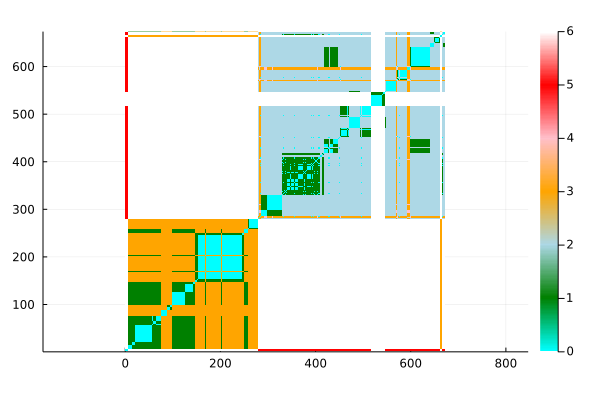

In [68]:
tcolors = reverse([:white, :red, :pink, :orange, :lightblue, :green, :aqua]);
heatmap(taxanomicdistance[order, order], c=tcolors, ratio=1)

In [69]:
savefig(joinpath(pdir, "taxanomic_distmtx_heatmap.pdf"))

# Adams plot

In [11]:
bmask = biobank.obs.phylum .== "Bacteroidetes"
fmask = biobank.obs.phylum .== "Firmicutes";

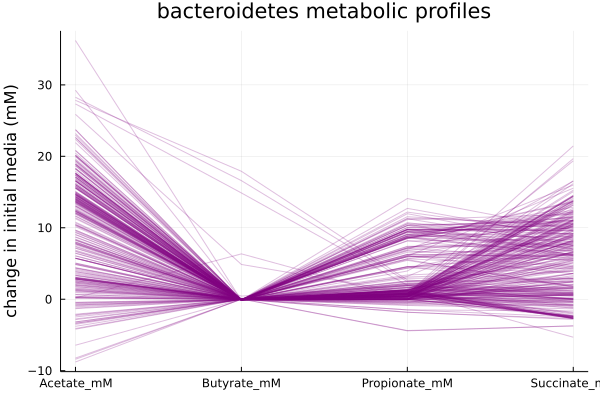

In [14]:
bb673mm = biobank["metabolites_millimolar"].layers["raw"][:,[4,1,2,3]][bmask, :];
plot(bb673mm', 
    title="bacteroidetes metabolic profiles",
    ylabel="change in initial media (mM)",
    c=:purple, 
    label="", 
    alpha=.25,
    xticks=(1:4,biobank["metabolites_millimolar"].var_names[[4,1,2,3]]),
)

In [15]:
savefig(joinpath(pdir, "bacteroidetes_metabolicprofiles_raw-deltamM.pdf"))

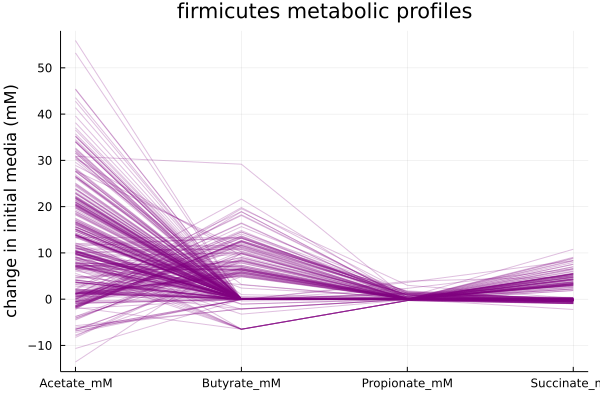

In [16]:
bb673mm = biobank["metabolites_millimolar"].layers["raw"][:,[4,1,2,3]][fmask, :];
plot(bb673mm', 
    title="firmicutes metabolic profiles",
    ylabel="change in initial media (mM)",
    c=:purple, 
    label="", 
    alpha=.25,
    xticks=(1:4,biobank["metabolites_millimolar"].var_names[[4,1,2,3]]),
)

In [17]:
savefig(joinpath(pdir, "firmicutes_metabolicprofiles_raw-deltamM.pdf"))

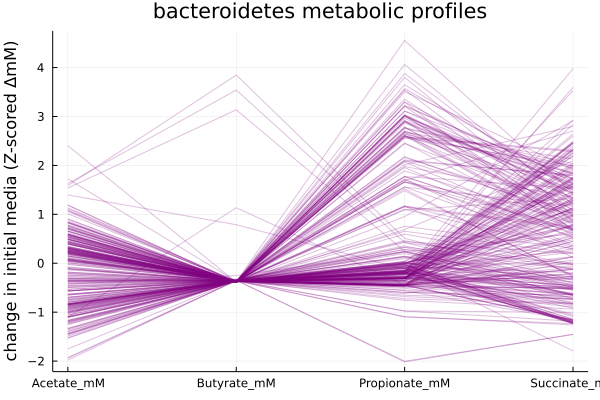

In [22]:
bb673mm = biobank["metabolites_millimolar"].X[:,[4,1,2,3]][bmask, :];
plot(bb673mm', 
    title="bacteroidetes metabolic profiles",
    ylabel="change in initial media (Z-scored ΔmM)",
    c=:purple, 
    label="", 
    alpha=.25,
    xticks=(1:4,biobank["metabolites_millimolar"].var_names[[4,1,2,3]]),
)

In [23]:
savefig(joinpath(pdir, "bacteroidetes_metabolicprofiles.pdf"))

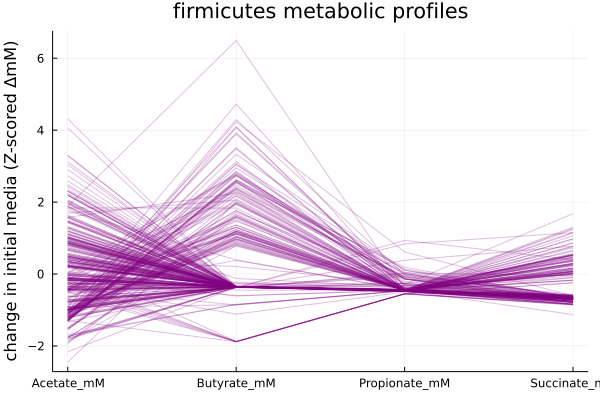

In [24]:
bb673mm = biobank["metabolites_millimolar"].X[:,[4,1,2,3]][fmask, :];
plot(bb673mm', 
    title="firmicutes metabolic profiles",
    ylabel="change in initial media (Z-scored ΔmM)",
    c=:purple, 
    label="", 
    alpha=.25,
    xticks=(1:4,biobank["metabolites_millimolar"].var_names[[4,1,2,3]]),
)

In [25]:
savefig(joinpath(pdir, "firmicutes_metabolicprofiles.pdf"))